In this EDA I will perform hierarchical clustering of the scans in the sample subset based on the frequency of pixels with given radiodensitites (binning Hounsfield Units [HU]). I will display a heatmap showing the different frequencies of the HU bins. Finally, we will look to see if the clusters formed distinguish between scans with and without cancer. I do not expect this simple clustering to be able to discriminate between cancerous and non-cancerous scans, especially when performed on this small subset of the data, but it is an exercise to become comfortable with the data type, the Hounsfield Unit scale, and the notion that there will be an association between pixel values and diagnosis. Ultimately, I plan to rely on convolutional neural networks to learn diagnosis from the images.

I will use some of the same pre-processing code which I described in the EDA 1 notebook to read in the DICOM files and convert the pixels to HU. Shout out to Guido Zuidhof for help with the pre-processing code (https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial).

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import seaborn as sns;

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = 'DataScienceBowl2017_Data/stage2/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [2]:
# This function will load the scan for a given patient and infer the slice thickness for each scan
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
# This function will convert pixels to Hounsfield Units
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices]) #make 3D arrays combining all slices for each patient 
    image = image.astype(np.int16) #convert to int16

    # Pixels that were outside the scanning bounds have been set to -2000
    # Reset to have HU of air = 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept #RescaleIntercept included in metadata of pic
        slope = slices[slice_number].RescaleSlope #RescaleIntercept included in metadata of pic
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Read in each of 20 images and change to HU scale:

In [4]:
allscans = []
allhu = []
for patient in patients:
    patient_scan = load_scan(INPUT_FOLDER + patient)
    allscans.append(patient_scan)
    patient_hu = get_pixels_hu(patient_scan)
    allhu.append(patient_hu)

Flatten each patients scan to a single vector:

In [5]:
flathu = []
for hu in allhu:
    flathu.append(hu.flatten())

#take a look at resulting structure
print(len(flathu))
print(flathu[0].shape) #each scan is now represented as a vector of length 35127296

20
(35127296,)


We will now bin the pixels based on which substance they most likely represent, and then for each patient, derive the frequency of each substance in his or her scan:

In [6]:
#for each image, derive density distribution of HU bins
bins = [-1500,-750,-250,-99,1,11,61,101,701,3001]
HU_hist_data = [] #store the distribution of substances for each scan
for i in range(len(flathu)):
    freq, bins = np.histogram(flathu[i], bins, density = True)
    HU_hist_data.append(freq)


I used the table provided on  [Wikipedia](http://en.wikipedia.org/wiki/Hounsfield_scale#Value_in_parts_of_the_body) to approximate the substance represented by each bin of HU values, and stored the substance name in the "HU_cats" array below:


In [7]:
HU_cats = ['air', 'lung', 'fat', 'water', 'CSF', 'blood & muscle', 'soft tissue', 'cancellous bone', 'cortical bone']

We are now ready to draw our heatmap, which will visualize the densities of the different substances across patient scans, and will also cluster the patients on this density data.

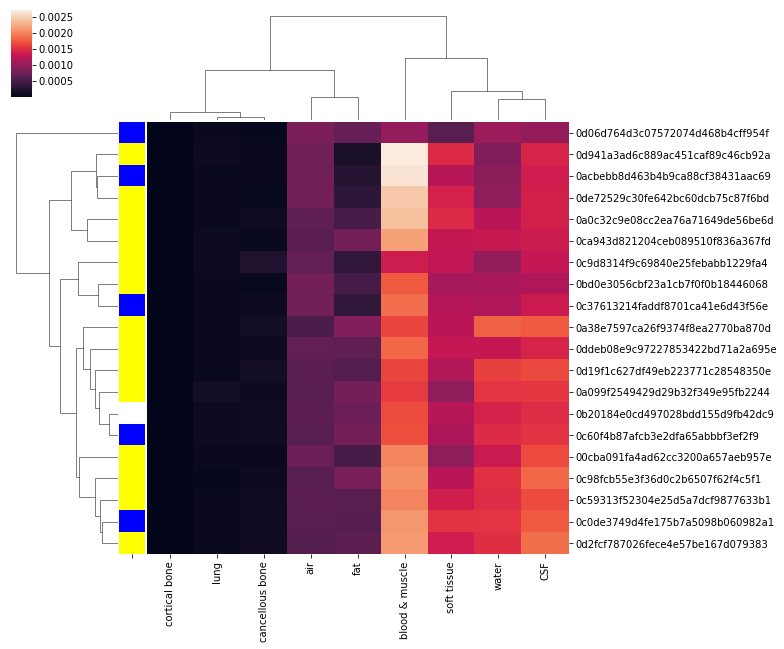

In [8]:
HU_df = pd.DataFrame(HU_hist_data, index = patients, columns = HU_cats)

#read in diagnosis labels (1: cancer, 0: no cancer) to annotate rows in heatmap
diagnoses = pd.read_csv("../input/stage1_labels.csv")

#create color scheme for diagnosis annotation bar in heatmap
color = pd.Series(data = np.array(diagnoses['cancer']), index = diagnoses['id'])
hm_colors = color[patients]
color_map = {0.0: "yellow", 1.0: "blue"}
hm_colors2 = hm_colors.map(color_map)

#draw clustered heatmap
sns.clustermap(HU_df, row_colors= hm_colors2)

In the heatmap above, scans/patients annotated yellow were cancer free, and scans annotated blue received a positive lung cancer diagnosis. As expected, we don't see separation of our two classes of patients (those with lung cancer & those without) when clustering over this density data. From this heatmap, we are able to see that most of the pixels in each scan represent blood, muscle, soft tissue, water, and CSF, a smaller portion represent fat and air, and a very small portion of pixels represent lung and bone. This is surprising, as we would expect much of the chest CT scans to consist of lung and air, and we know that there is significant bone in these scans as I produced a 3D visualization of only the bone portion of a scan in my notebook EDA1_visualize3D.ipynb. This result will need to be further investigated as I move forward with this project. It is possible that there was an error or mis-assumption in this analysis, or it may be  the case that this distribution is biologically true of chest CT scans, and only after I segment each scan into its different tissue types will I be able to focus on the lung portion of each scan.